# Kernel Text Proximity

## Purpose
Here we present the *kernel text proximity*, how to use the current implementation to search for hyperparameters and evaluate pairs of texts, and compare it with some others methods

## Description of word proximity
 A text consists in sequence of words, and words can be represented by a N-dimensional vector (N=300 usually so as here). We add a dimension to those vector, the *sequence* dimension: each vector in the word sequence of a text is separated by the next one by a given distance s.t. the distance between the first and the last word of a text reaches a certain *length*. This *length* of a text representation on the sequence axis is a hyperparameter to fix.
 
 When we want to estimate the semantic proximity between two text, we embed them in the same N+1 dimensional space (+1 because we added the seuential dimension):

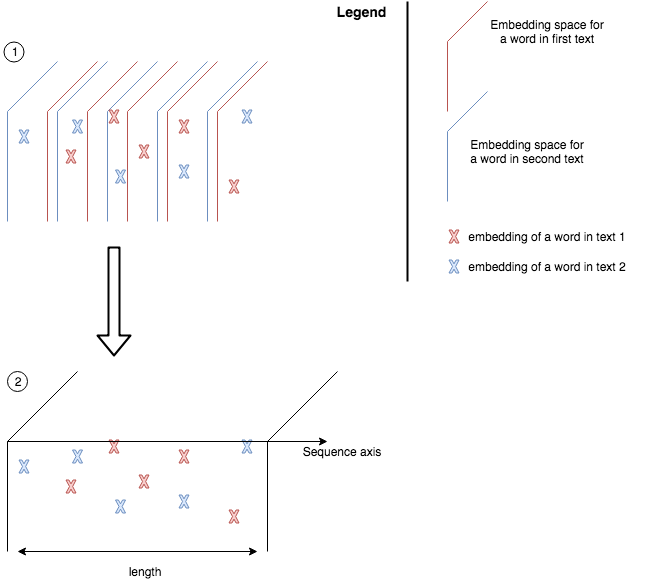

In [8]:
from IPython.display import Image
Image("../text_embedding.png")

Then, for a word of the text having the shortest sequence, we compute the kernel weight of each word in the other text and sum it. We do it for each word, and take the mean value of it. Mathematically, assuming $text_0$ is the shortest text: 

$$ kernel\_proximity(text_0, text_1) := \frac{1}{\#text_0}\sum_{w_0\in text_0}\sum_{w_1\in text_1}Kernel\big(dist(w_0, w_1)\big) $$

## Example on Quora duplicate questions dataset

The quora dataset is available on [Kaggle](https://www.kaggle.com/quora/question-pairs-dataset). It's a csv file where each entry contains the fields *question1* and *question2* and the corresponding label *is_duplicate*. The assumption is: the closer *question1* and *question2*, the likelier should they be duplicates.

In [9]:
import os
import pandas as pd
from kernel_text_proximity import *

df_quora = pd.read_csv(os.path.join(*['data', 'questions.csv'])).dropna().reset_index(drop=True)

df_quora.head()
print('\nNumber of rows in df_quora: {}'.format(df_quora.shape[0]))


Number of rows in df_quora: 404348


We define the path to the embedding file. The embedding file should be in [GloVe format](https://radimrehurek.com/gensim/scripts/glove2word2vec.html).

In [10]:
NLP_RESOURCE_DIRECTORY = os.path.join(os.path.expanduser('~'), 'nlp-resources')
word_embedding_file_path = os.path.join(NLP_RESOURCE_DIRECTORY, 'glove.840B.300d.txt')

## Calibrating the *kernel text proximity* model

Now we look for the best hyperparameters for the *kernel text proximity* model on a random sample of 10000 entries in *df_quora*. Those hyperparameter are:
* kernel (one of 'gaussian', 'inverse' etc.)
* length parameter for the kernel (length of the sequence axis in the text embedding)
* normalize: normalize the word embeddings or not?


In [12]:
kernels = ['gaussian', 'inverse', 'triangle', 'epanechnikov', 'quadratic', 'cubic', 'circular', 'student']
search_space_l = np.linspace(.01, 1, 1000)
search_space_eps = np.linspace(.001, .1, 1000)
# search_space_scale = np.random.uniform(0, 1, 1000)
# search_space_length = np.random.uniform(0, 1, 1000)
normalize_values = [True, False]
distances_values = ['euclidian', 'cosine']

n_sample = 1000  # Sample size of the calibration dataset

We extract *n\_sample = 1000* rows out of *df_quora* (that contains 404k rows):

In [13]:
df_quora_calibration = df_quora.iloc[np.random.choice(list(range(df_quora.shape[0])), size=n_sample, replace=False)].reset_index(drop=True)

Now we search at random between all (*prop=1*) the combinations of hyperparameter values, and stop after *patience = 500* trials without improvement. The performance is measured as the [average precision](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) obtained by predicting *is_duplicate* according to the *kernel text proximity*.

In [14]:
kernel_best, scale_best, length_best, normalize_best, distance_best, ap_score_best = calibrate(articles_0=df_quora_calibration['question1'].tolist(),  
                                                                                articles_1= df_quora_calibration['question2'].tolist(),  
                                                                                true_values=df_quora_calibration['is_duplicate'],  
                                                                                word_embedding_file_path=word_embedding_file_path,  
                                                                                scale_values=search_space_scale, 
                                                                                length_values=search_space_length, 
                                                                                normalize_values=normalize_values, 
                                                                                kernels=kernels, 
                                                                                distances= distances_values,
                                                                                prop=1, 
                                                                                patience=500, 
                                                                                language='english')

INFO    : 2018-11-07 00:43:45,611, kernel_text_proximity, calibrate: Searching for best scale and length values...
INFO    : 2018-11-07 00:43:56,965, kernel_text_proximity, get_relevant_embeddings: computing relevant word embeddings...
INFO    : 2018-11-07 00:44:28,843, kernel_text_proximity, get_relevant_embeddings: relevant word embeddings computed in 31.9s
INFO    : 2018-11-07 00:44:29,042, kernel_text_proximity, calibrate: Better parameters found: kernel='student', scale_best=0.8655885737518525, length_best=0.8649134303520642, normalize=True, distance_best: euclidian,  corresponding best average precision: 0.33700524736416293
INFO    : 2018-11-07 00:44:29,284, kernel_text_proximity, calibrate: Better parameters found: kernel='student', scale_best=0.08126326766739311, length_best=0.9649084623648406, normalize=True, distance_best: cosine,  corresponding best average precision: 0.519037401208948
INFO    : 2018-11-07 00:44:31,515, kernel_text_proximity, calibrate: Better parameters fou

On this subset:
* the cosine distance seems to completely outperform the euclidian distance: at no point a better score has been reached with euclidian distance
* not normalizing the word embedding seems to be better than normalizing them

We can now make a Bayesian hyperparameter optimization with the best *kernel* and *normalize* values found in the previous step:

In [15]:
hyperparameters_best = calibrate_bayes(articles_0=df_quora_calibration['question1'].tolist(), 
                       articles_1=df_quora_calibration['question2'].tolist(), 
                       true_values=df_quora_calibration['is_duplicate'], 
                       scale_range=(0.01, 0.05),
                       length_range=(.4, .8),
                       kernel=kernel_best, 
                       max_evals=1000,
                       normalize=normalize_best,
                       distance=distance_best,
                       word_embedding_file_path=word_embedding_file_path)

hyperparameters_best

INFO    : 2018-11-07 00:55:45,912, kernel_text_proximity, calibrate_bayes: Starting Bayes hyperparameter optimization...
INFO    : 2018-11-07 00:55:45,914, kernel_text_proximity, get_relevant_embeddings: computing relevant word embeddings...
INFO    : 2018-11-07 00:56:16,346, kernel_text_proximity, get_relevant_embeddings: relevant word embeddings computed in 30.4s
INFO    : 2018-11-07 01:00:35,185, kernel_text_proximity, calibrate_bayes: Bayes hyperparameter optimization finished in 289.3s


{'length': 0.6143834939655792, 'scale': 0.03137947198254179}

The values obtained here are very close to the ones obtained previously, we replace them:

In [16]:
scale_best, length_best = hyperparameters_best['scale'], hyperparameters_best['length']

We can test the [word mover distance](http://proceedings.mlr.press/v37/kusnerb15.pdf) on this calibration dataset, using the same standard text pre-processing than used for the *kernel text proximity*:

In [17]:
from gensim.test.utils import  get_tmpfile
from gensim.models import KeyedVectors

stop_words = get_stop_words(language='english')

sentences_0 = [[w for w in re.findall(r'\w+', sentence.lower()) if w not in stop_words] for sentence in df_quora_calibration['question1'].tolist()]
sentences_1 = [[w for w in re.findall(r'\w+', sentence.lower()) if w not in stop_words] for sentence in df_quora_calibration['question2'].tolist()]

NLP_RESOURCE_DIRECTORY = os.path.join(os.path.expanduser('~'), 'nlp-resources')
tmp_file = get_tmpfile(os.path.join(NLP_RESOURCE_DIRECTORY, 'word2vec.840B.300d.txt'))

print('loading model...')
t0 = time.time()
model = KeyedVectors.load_word2vec_format(tmp_file)
print('model loaded in {}s'.format(round(time.time() - t0, 1)))

wmd_distances = []
for i in range(n_sample):
    # model.wmdistance requires package pyemd
    wmd_distance = model.wmdistance(sentences_0[i], sentences_1[i])
    wmd_distances.append(wmd_distance)
    
min_wmd_distance, max_wmd_distance = min(wmd_distances), max([wd for wd in wmd_distances if wd < np.inf])
scores = pd.Series([(d - min_wmd_distance) / (max_wmd_distance - min_wmd_distance) for d in wmd_distances])
scores = 1 - scores

aps = average_precision_score(df_quora_calibration['is_duplicate'][scores > -np.inf], scores[scores > -np.inf])
print('average precision score with wmd: {}'.format(aps))

loading model...
model loaded in 396.3s
average precision score with wmd: 0.5772478005748066


On this subset, *word mover distance* outperforms *kernel text proximity* (average precision score = 0.577 vs. 0.555). The baseline for the average precision on this subset (proportion of rows with *is_duplicate==True* is:

In [18]:
df_quora_calibration['is_duplicate'].sum() / df_quora_calibration.shape[0]

0.348

## Assessing the *kernel text proximity* model
Now we use the hyperparameter found previously for this model and apply them to classify the whole *df_quora* dataset:

In [19]:
print('hyperparameter used:\n * scale: {}\n * length: {}\n * kernel: {}\n * distance: {}\n * normalize: {}'.format(scale_best, length_best, kernel_best, distance_best, normalize_best))

ktp_scores = evaluate(articles_0=df_quora['question1'].tolist(),
         articles_1=df_quora['question2'].tolist(),
         scale=scale_best, 
         length=length_best, 
         word_embedding_file_path=word_embedding_file_path, 
         kernel=kernel_best, 
         distance=distance_best,
         normalize=normalize_best,
         language='english')

ktp_aps = average_precision_score(df_quora['is_duplicate'][scores >= 0], scores[scores >= 0])

print('\naverage precision score with kernel text proximity: {}'.format(round(ktp_aps, 3)))

INFO    : 2018-11-07 01:14:16,109, kernel_text_proximity, get_relevant_embeddings: computing relevant word embeddings...


hyperparameter used:
 * scale: 0.03137947198254179
 * length: 0.6143834939655792
 * kernel: epanechnikov
 * distance cosine
 * normalize: False


INFO    : 2018-11-07 01:23:27,065, kernel_text_proximity, get_relevant_embeddings: relevant word embeddings computed in 551.0s
INFO    : 2018-11-07 01:23:27,080, kernel_text_proximity, evaluate: computing pair scores...
INFO    : 2018-11-07 01:25:07,316, kernel_text_proximity, evaluate: scores for 404348 pairs computed in 100.2s



average precision score with kernel text proximity: 0.534


Even with additional rounds of hyperparamter optimization we couldn't go higher than 0.541...

As comparison, we compare it with the (average precision) score obtained with *word mover distance*:

In [8]:
sentences_0 = [[w for w in re.findall(r'\w+', sentence.lower()) if w not in stop_words] for sentence in df_quora['question1'].tolist()]
sentences_1 = [[w for w in re.findall(r'\w+', sentence.lower()) if w not in stop_words] for sentence in df_quora['question2'].tolist()]

print('computing wmd distances...')
t0 = time.time()
wmd_distances = []
for i in range(df_quora.shape[0]):
    wmd_distance = model.wmdistance(sentences_0[i], sentences_1[i])
    wmd_distances.append(wmd_distance)
print('wmd distances for {} paires computed in {}s'.format(df_quora.shape[0], round(time.time() - t0, 1)))
    
min_wmd_distance, max_wmd_distance = min(wmd_distances), max([wd for wd in wmd_distances if wd < np.inf])
wmd_scores = pd.Series([(d - min_wmd_distance) / (max_wmd_distance - min_wmd_distance) for d in wmd_distances])
wmd_scores = 1 - scores

wmp_aps = average_precision_score(df_quora['is_duplicate'][scores > -np.inf], scores[scores > -np.inf])
print('average precision score with wmd: {}'.format(round(wmd_aps, 3)))

computing wmd distances...
wmd distances for 404348 paires computed in 259.2s
average precision score with wmd: 0.575


The baseline of the average precision score on the whole *df_quora* dataset (proportion of rows with *is_duplicate==True*) is:

In [ ]:
df_quora['is_duplicate'].sum() / df_quora.shape[0]

*TODO:* plot precision_recall curve
*TODO:* we can also compare with a simple cosine distance approach (describe and compute it)

## Conclusion
* On 